<a href="https://colab.research.google.com/github/srujan-bandla/srujan_INFO5731_Fall2022/blob/main/In_class_exercise/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/28/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# Write your code here
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 41.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import pandas as pd
df = pd.read_csv("sorted_results.csv")

# Cleaning the data
import re

def cleantext(reviews):
    text = re.sub(r'@[A-Za-z0-9_]+', '', reviews) # Removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) # Removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) # Removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub("[^A-Za-z0-9]", " ", text) # Filtering non-alphanumeric characters
    text = re.sub('\n', '', text) # Removing the '\n' character
    text = re.sub(r'[0-9]+', '', text) # Removing numbers

    return text

df["Review"] = df["Review"].apply(cleantext)

# Convert to a list
data = df.Review.values.tolist()


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [8]:
b = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
t = gensim.models.Phrases(b[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bmod = gensim.models.phrases.Phraser(b)
tmod = gensim.models.phrases.Phraser(t)

# See trigram example
print(tmod[bmod[data_words[0]]])

['love', 'to', 'go', 'back']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bmod[doc] for doc in texts]

def make_trigrams(texts):
    return [tmod[bmod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['love', 'go', 'back']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [12]:
id2word[0]

'back'

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('back', 1), ('go', 1), ('love', 1)]]

In [14]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.094*"get" + 0.054*"well" + 0.047*"steak" + 0.022*"table" + 0.021*"seat" + 0.018*"need" + 0.017*"owner" + 0.017*"fry" + 0.017*"hot" + 0.014*"come"'), (1, '0.061*"ever" + 0.044*"pretty" + 0.026*"meal" + 0.021*"home" + 0.018*"beef" + 0.018*"day" + 0.017*"meat" + 0.015*"cold" + 0.014*"know" + 0.013*"avoid"'), (2, '0.180*"service" + 0.037*"sauce" + 0.024*"salad" + 0.021*"slow" + 0.020*"feel" + 0.018*"tasty" + 0.016*"talk" + 0.016*"bar" + 0.015*"customer" + 0.014*"enjoy"'), (3, '0.085*"go" + 0.065*"back" + 0.043*"time" + 0.032*"come" + 0.028*"staff" + 0.026*"even" + 0.024*"definitely" + 0.020*"probably" + 0.019*"selection" + 0.016*"flavor"'), (4, '0.057*"also" + 0.050*"restaurant" + 0.037*"nice" + 0.033*"taste" + 0.027*"fresh" + 0.023*"atmosphere" + 0.023*"portion" + 0.023*"next" + 0.019*"bit" + 0.018*"hour"'), (5, '0.053*"take" + 0.030*"night" + 0.028*"burger" + 0.025*"money" + 0.022*"small" + 0.021*"worth" + 0.017*"waste" + 0.017*"drive" + 0.015*"establishment" + 0.015*"disappointi

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.34676149063252

Coherence Score:  0.5991305798985206


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.324806  0.060690       1        1  18.543994
3     -0.070632  0.314764       2        1  14.839548
6      0.147642 -0.083077       3        1  12.842737
9     -0.072006 -0.060758       4        1  10.000915
0     -0.080988  0.031927       5        1   8.810623
4     -0.070053 -0.025366       6        1   8.133808
2     -0.052994 -0.091708       7        1   8.028520
1     -0.046325 -0.065217       8        1   7.404853
8     -0.041857 -0.066540       9        1   5.952182
5     -0.037593 -0.014716      10        1   5.442820, topic_info=            Term        Freq       Total Category  logprob  loglift
35          good  118.000000  118.000000  Default  30.0000  30.0000
80       service   70.000000   70.000000  Default  29.0000  29.0000
34          food   99.000000   99.000000  Default  28.0000  28.0000
1             go   71.000000   71.000000  Default  27.0000  27.0000
124          get   40.000000   40.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1274     mention    1.436485    2.154435  Topic10  -5.2058   2.5055
1275        pear    1.436485    2.154435  Topic10  -5.2058   2.5055
69    experience    2.899826   16.020170  Topic10  -4.5033   1.2017
18          much    2.277618   12.673142  Topic10  -4.7449   1.1945
4           time    2.865865   39.398026  Topic10  -4.5151   0.2900

[353 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
622       3  0.894376  absolutely
1273     10  0.464159      almond
142       6  0.960487        also
209       3  0.983437      always
535       3  0.970576     amazing
...     ...       ...         ...
131       9  0.841634   wonderful
703       7  0.883766       world
303      10  0.805462       worth
356       4  0.935999       wrong
585       5  0.920305         yet

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 7, 10, 1, 5, 3, 2, 9, 6])

In [22]:
from gensim import corpora, models
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel

# Create a dictionary and corpus
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(doc) for doc in data_lemmatized]

# Train an LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=20)

# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(16,
  [('great', 0.02404865),
   ('place', 0.021879416),
   ('pizza', 0.01103062),
   ('long', 0.011030471),
   ('come', 0.011030414),
   ('dish', 0.011030123),
   ('think', 0.011029983),
   ('back', 0.011029573),
   ('food', 0.011029102),
   ('order', 0.01045181)]),
 (12,
  [('good', 0.03010463),
   ('get', 0.029669916),
   ('place', 0.029649287),
   ('service', 0.022266533),
   ('come', 0.019807173),
   ('back', 0.019805733),
   ('time', 0.017372634),
   ('also', 0.012917884),
   ('recommend', 0.01242561),
   ('amazing', 0.0124251135)]),
 (2,
  [('good', 0.056325834),
   ('place', 0.042280395),
   ('service', 0.02542226),
   ('food', 0.025422145),
   ('great', 0.012502581),
   ('nice', 0.011645389),
   ('pretty', 0.011376717),
   ('ever', 0.008568313),
   ('never', 0.008568267),
   ('lunch', 0.008568216)]),
 (6,
  [('go', 0.03923829),
   ('service', 0.039237626),
   ('food', 0.031654097),
   ('back', 0.018190002),
   ('good', 0.015182697),
   ('try', 0.012177976),
   ('dish', 0.012

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=6):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Call the function to compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


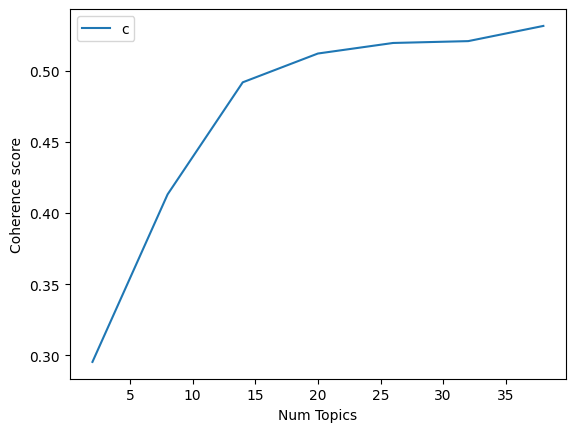

In [33]:
 # Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2954
Num Topics = 8  has Coherence Value of 0.4131
Num Topics = 14  has Coherence Value of 0.4918
Num Topics = 20  has Coherence Value of 0.512
Num Topics = 26  has Coherence Value of 0.5194
Num Topics = 32  has Coherence Value of 0.5207
Num Topics = 38  has Coherence Value of 0.5314


In [36]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.055*"place" + 0.022*"good" + 0.017*"overprice" + 0.017*"food" + '
  '0.014*"really" + 0.014*"service" + 0.014*"eat" + 0.014*"go" + 0.014*"great" '
  '+ 0.014*"much"'),
 (1,
  '0.049*"service" + 0.033*"food" + 0.031*"good" + 0.016*"place" + 0.016*"go" '
  '+ 0.014*"say" + 0.014*"back" + 0.013*"order" + 0.012*"also" + '
  '0.012*"pretty"'),
 (2,
  '0.048*"food" + 0.036*"get" + 0.016*"recommend" + 0.016*"good" + '
  '0.012*"place" + 0.012*"amazing" + 0.012*"service" + 0.008*"fantastic" + '
  '0.008*"equally" + 0.008*"special"'),
 (3,
  '0.028*"friendly" + 0.027*"food" + 0.018*"also" + 0.016*"try" + '
  '0.016*"waitress" + 0.012*"always" + 0.012*"experience" + 0.012*"go" + '
  '0.012*"deal" + 0.008*"sure"'),
 (4,
  '0.040*"back" + 0.029*"come" + 0.022*"wait" + 0.018*"think" + 0.018*"great" '
  '+ 0.011*"salad" + 0.011*"table" + 0.011*"soon" + 0.011*"nice" + '
  '0.011*"definitely"'),
 (5,
  '0.054*"food" + 0.030*"good" + 0.016*"well" + 0.016*"place" + 0.014*"get" + '
  '0.012*"re

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [37]:
# Write your code here
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [44]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)

[['love', 'go', 'back'],
 ['come', 'back', 'everi', 'time', 'vega'],
 ['check', 'place', 'coupl', 'year', 'ago', 'impress'],
 ['think', 'go', 'back', 'anytim', 'soon'],
 ['hate', 'thing', 'much', 'cheap', 'qualiti', 'black', 'oliv'],
 ['overal', 'like', 'place', 'lot'],
 ['worst', 'sushi', 'ever', 'eat', 'besid', 'costco'],
 ['hard', 'make', 'decent', 'hamburg'],
 ['much',
  'good',
  'food',
  'vega',
  'feel',
  'cheat',
  'wast',
  'eat',
  'opportun',
  'go',
  'rice',
  'compani'],
 ['small', 'famili', 'restaur', 'fine', 'dine', 'establish'],
 ['love',
  'put',
  'food',
  'nice',
  'plastic',
  'contain',
  'oppos',
  'cram',
  'littl',
  'paper',
  'takeout',
  'box'],
 ['wait', 'go', 'back'],
 ['needless', 'say', 'never', 'back'],
 ['hope', 'bode', 'go', 'busi', 'someon', 'cook', 'come'],
 ['mani', 'word', 'say', 'place', 'everyth', 'pretti', 'well'],
 ['come',
  'like',
  'experienc',
  'underwhelm',
  'relationship',
  'parti',
  'wait',
  'person',
  'ask',
  'break'],
 ['le

In [45]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [46]:
number_of_topics=7
words=10

In [47]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [48]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [49]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

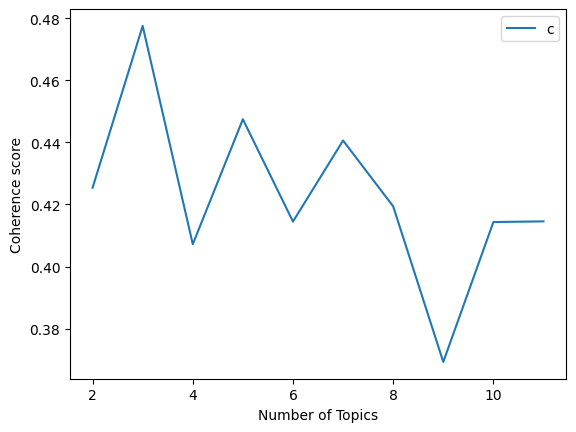

In [50]:
start,stop,step=2,12,1
plot_graph(preprocess_data(data),start,stop,step)

In [51]:
# Write your code here
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)

[(0, '0.654*"food" + 0.368*"good" + 0.328*"place" + 0.292*"servic" + 0.215*"great" + 0.134*"go" + 0.110*"time" + 0.109*"like" + 0.094*"back" + 0.079*"realli"'), (1, '-0.770*"place" + 0.403*"food" + -0.211*"go" + -0.171*"back" + 0.170*"good" + 0.149*"servic" + -0.104*"would" + -0.091*"time" + -0.082*"like" + -0.076*"never"'), (2, '0.708*"good" + -0.401*"servic" + -0.399*"great" + -0.150*"back" + 0.143*"place" + -0.139*"go" + -0.117*"time" + 0.095*"realli" + -0.079*"friendli" + -0.061*"server"'), (3, '-0.542*"back" + -0.475*"go" + 0.361*"place" + -0.259*"good" + 0.256*"great" + -0.241*"time" + 0.214*"food" + -0.108*"servic" + -0.098*"never" + -0.083*"come"'), (4, '-0.511*"food" + 0.496*"servic" + 0.405*"great" + 0.404*"good" + -0.156*"go" + -0.139*"wait" + -0.091*"back" + -0.090*"minut" + 0.072*"friendli" + -0.059*"time"'), (5, '-0.658*"great" + 0.569*"servic" + 0.239*"like" + -0.153*"back" + -0.152*"time" + 0.130*"place" + -0.114*"good" + -0.090*"go" + 0.083*"slow" + 0.063*"feel"'), (6,

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [71]:
!pip install git+https://github.com/bmabey/pyLDAvis.git@14e7b5f60d8360eb84969ff08a1b77b365a5878e#egg=pyLDAvis

  Cloning https://github.com/bmabey/pyLDAvis.git (to revision 14e7b5f60d8360eb84969ff08a1b77b365a5878e) to /tmp/pip-install-0yilg8yt/pyldavis_483aa183d3fa4258b72b10de016e7afc
  Running command git clone --filter=blob:none --quiet https://github.com/bmabey/pyLDAvis.git /tmp/pip-install-0yilg8yt/pyldavis_483aa183d3fa4258b72b10de016e7afc
  Running command git rev-parse -q --verify 'sha^14e7b5f60d8360eb84969ff08a1b77b365a5878e'
  Running command git fetch -q https://github.com/bmabey/pyLDAvis.git 14e7b5f60d8360eb84969ff08a1b77b365a5878e
  Running command git checkout -q 14e7b5f60d8360eb84969ff08a1b77b365a5878e
  Resolved https://github.com/bmabey/pyLDAvis.git to commit 14e7b5f60d8360eb84969ff08a1b77b365a5878e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install --upgrade lda2vec

from lda2vec import preprocess,Corpus
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

In [6]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [53]:
!pip install lda2vec

  Preparing metadata (setup.py) ... done
  Created wheel for lda2vec: filename=lda2vec-0.16.10-py3-none-any.whl size=14410 sha256=b1be1104489ca6fab3245e4aed4673fca529ddfd31d1e68ab3bd65de9cbb694c
  Stored in directory: /root/.cache/pip/wheels/1e/90/24/a97126c0fe8b479ba3bb79d3b18ebaab571a18d90bb2967ab6
Successfully built lda2vec


In [7]:
import numpy as np

# Open the .npz file in binary mode 'rb'
npz = np.load(open('topics.pyldavis.npz', 'rb'))

# Load the data into a dictionary
dat = {k: v for k, v in npz.items()}

# If needed, convert the 'vocab' to a list
dat['vocab'] = dat['vocab'].tolist()

# Optionally, you can perform other operations on the loaded data
# dat['term_frequency'] = dat['term_frequency'] * 1.0 / dat['term_frequency'].sum()


In [9]:
top_n = 30
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print(msg)
    topic_to_topwords[j] = top_words

Topic 0 jesus god orthodox faith verse worship belief christianity christian mormon divine biblical truth disprove messiah protestant atheist kingdom luke spirit pentecostal scripture gospel absolute incarnate eternal evidence be teaching salvation
Topic 1 bike tire honda battery brake ride valve aluminum intake jeep tank hose heat plastic outlet cleaner mile car misfire injector electric compartment exhaust engine motorcycle countersteering speedometer quack odometer a
Topic 2 game team play win baseball score playoff mets goal phillies espn stadium catcher puck pitching season player pitch pitcher phils fan lopez shot toronto detroit alomar he nhl habs oiler
Topic 3 shuttle nasa space payload computational planetary satellite mission launch lunar jpl material visualization online available astronomy archive research ftp sphinx ozone internet orbit orbital propulsion molecular information analysis magellan data
Topic 4 armenian troop cyprus israel soldier agdam bayonet terror bullet h

In [26]:
from sklearn.datasets import fetch_20newsgroups
remove=('headers', 'footers', 'quotes')
texts = fetch_20newsgroups(subset='train', remove=remove).data

In [32]:
print (texts[1])


A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.


In [34]:
msg = "{weight:02d}% in topic {topic_id:02d} which has top words {text:s}"
for topic_id, weight in enumerate(dat['doc_topic_dists'][1]):
    if weight > 0.01:
        text = ', '.join(topic_to_topwords[topic_id])
        print (msg.format(topic_id=topic_id, weight=int(weight * 100.0), text=text))

07% in topic 01 which has top words bike, tire, honda, battery, brake, ride, valve, aluminum, intake, jeep, tank, hose, heat, plastic, outlet, cleaner, mile, car, misfire, injector, electric, compartment, exhaust, engine, motorcycle, countersteering, speedometer, quack, odometer, a
02% in topic 03 which has top words shuttle, nasa, space, payload, computational, planetary, satellite, mission, launch, lunar, jpl, material, visualization, online, available, astronomy, archive, research, ftp, sphinx, ozone, internet, orbit, orbital, propulsion, molecular, information, analysis, magellan, data
24% in topic 05 which has top words drive, controller, battery, dock, connector, ink, card, slot, pin, vram, monitor, simms, quadra, cable, hd, i, amp, disk, mfm, warranty, switch, motherboard, electronics, mono, centris, mount, isa, a, hook, wire
05% in topic 11 which has top words widget, server, contrib, font, editor, format, mit, pixmap, toolkit, binary, motif, ftp, bitmap, icon, image, directory

<BarContainer object of 20 artists>

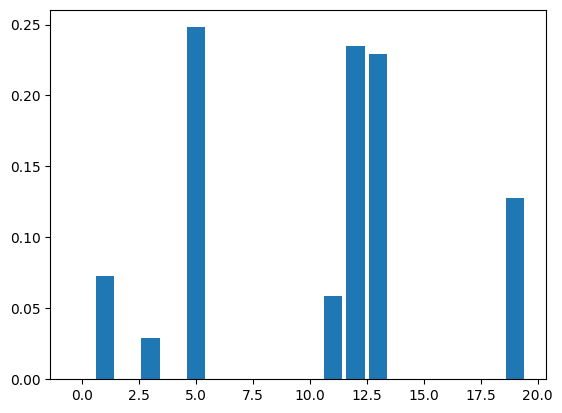

In [36]:
import matplotlib.pyplot as plt
plt.bar(np.arange(20), dat['doc_topic_dists'][1])

In [42]:
#Removing the numbers from the news text
for letter in '1234567890.(/':
    data['News_text']= data['News_text'].str.replace(letter,'')

In [43]:
#Remving the single letters (like, "u", "w" etc) from the text
data['News_text']=data['News_text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

In [45]:
from nltk.tokenize import RegexpTokenizer

# Create a RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Apply the tokenizer to your text data
data['News_text'] = data['News_text'].apply(lambda text: tokenizer.tokenize(text))


In [47]:
import nltk
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

In [48]:
data['News_text']=data['News_text'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [49]:
data['News_text'].head()

0    [wondering, anyone, could, enlighten, car, saw...
1    [fair, number, brave, souls, upgraded, si, clo...
2    [well, folks, mac, plus, finally, gave, ghost,...
3    [weitek, addressphone, number, like, get, info...
4    [article, cowcbnp, worldstdcom, tombaker, worl...
Name: News_text, dtype: object

In [50]:
#Description of news text information
all_words = [word for tokens in data['News_text'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data['News_text']]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1275954 words total, with a vocabulary size of 88522
Max sentence length is 13798


In [51]:
from collections import Counter
counter = Counter(all_words)
counter.most_common(20)

[('ax', 62452),
 ('x', 8237),
 ('q', 6599),
 ('one', 6408),
 ('would', 6160),
 ('w', 5720),
 ('max', 4598),
 ('p', 4408),
 ('r', 4357),
 ('people', 4097),
 ('u', 3962),
 ('like', 3956),
 ('g', 3916),
 ('get', 3532),
 ('know', 3485),
 ('also', 3346),
 ('n', 3272),
 ('v', 3249),
 ('b', 3175),
 ('use', 3173)]

In [52]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

In [53]:
def LDA_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Words of Topic ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [54]:
data_text=pd.DataFrame(data['News_text'])
data_text=data_text.rename(columns={'News_text':'News_Text'})

In [55]:
train_ = [value[0] for value in data_text.iloc[0:].values]

In [56]:
num_topics = 20

In [58]:
import gensim
from gensim import corpora

# Your code for creating the dictionary
id2word1 = corpora.Dictionary(train_)


In [59]:
corpus1 = [id2word1.doc2bow(text) for text in train_]

In [60]:
#Calling the LDA model and feeding the calculated text, dictionary and topics
from gensim.models import ldamodel
lda2vec = ldamodel.LdaModel(corpus=corpus1, id2word=id2word1, num_topics=num_topics)

In [61]:
#Calling LDA_topics function and using lda2vec with selective topics
LDA_topics(lda2vec, num_topics)

,Words of Topic 01,Words of Topic 02,Words of Topic 03,Words of Topic 04,Words of Topic 05,Words of Topic 06,Words of Topic 07,Words of Topic 08,Words of Topic 09,Words of Topic 10,Words of Topic 11,Words of Topic 12,Words of Topic 13,Words of Topic 14,Words of Topic 15,Words of Topic 16,Words of Topic 17,Words of Topic 18,Words of Topic 19,Words of Topic 20
0,ax,ax,planes,car,one,team,macs,b,w,would,key,god,cover,x,god,canon,would,pts,one,drive
1,tyre,q,w,engine,people,gm,hudson,ax,x,like,keys,people,condition,file,jews,jpeg,one,period,would,card
2,q,w,kk,w,god,b,cdi,db,ww,one,chip,law,x,program,vs,lucifer,like,pt,get,scsi
3,courses,max,mydisplay,believers,would,van,adl,x,c,know,des,state,new,entry,would,people,good,play,use,windows
4,p,p,manhattan,k,said,nhl,duo,w,x_s,think,encryption,one,sale,c,people,would,think,pp,like,use
5,n,g,bronx,dealer,jesus,min,sink,cs,cx,people,n,israel,st,window,turkish,printer,people,chicago,also,mb
6,r,r,fps,miles,us,det,us,shameful,file,good,bit,evidence,price,use,one,deskjet,get,st,time,thanks
7,um,u,drain,cars,space,la,law,c,uw,well,encrypted,right,data,n,armenian,know,year,detroit,information,bit
8,max,v,blew,let,also,tor,bullock,geb,sqs,time,k,would,use,r,armenians,bj,know,pittsburgh,could,dos
9,trades,n,danny,new,time,nj,san,gordon,sp,get,number,government,offer,server,turkey,get,much,calgary,many,system


In [63]:
from gensim.models.coherencemodel import CoherenceModel

# Rest of your code
coherence_using_lda2vec = CoherenceModel(model=lda2vec, texts=train_, dictionary=id2word1, coherence='c_v')
coherence = coherence_using_lda2vec.get_coherence()
print('Coherence Score: ', round(coherence, 3))


Coherence Score:  0.588


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [2]:
# Write your code here
%%capture
!pip install bertopic

In [3]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [4]:
!pip install numba

from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

2023-11-05 22:13:51,229 - BERTopic - Transformed documents to Embeddings
2023-11-05 22:14:30,479 - BERTopic - Reduced dimensionality
2023-11-05 22:15:19,410 - BERTopic - Clustered reduced embeddings


In [5]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6721,-1_to_the_and_is,"[to, the, and, is, of, you, it, for, in, that]",[-------------------------------------------\n...
1,0,1845,0_game_team_games_he,"[game, team, games, he, players, season, hocke...",[I would appreciate it if someone could volunt...
2,1,590,1_key_clipper_chip_encryption,"[key, clipper, chip, encryption, keys, escrow,...",[The following document summarizes the Clipper...
3,2,525,2_ites_cheek_yep_huh,"[ites, cheek, yep, huh, ken, why, each, of, , ]","[\nHuh?, \nYep.\n, ites:]"
4,3,470,3_israel_israeli_jews_arab,"[israel, israeli, jews, arab, jewish, arabs, p...","[\nThis a ""tried and true"" method utilized by ..."


In [6]:
topic_model.get_topic(0)

[('game', 0.010240916402243233),
 ('team', 0.008933619881709995),
 ('games', 0.007119436810796315),
 ('he', 0.006973681523413118),
 ('players', 0.00627286964195401),
 ('season', 0.006192352094625621),
 ('hockey', 0.006082710041718968),
 ('play', 0.00572685972373355),
 ('25', 0.0055880997149137185),
 ('year', 0.00555525706779292)]

In [7]:
topic_model.visualize_topics()

In [8]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [9]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [10]:
similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

[8, 150, 80, 101, 58]

In [11]:
topic_model.get_topic(71)

[('mhz', 0.028151932828254764),
 ('bus', 0.020892260778421413),
 ('486dx250', 0.017757012457596123),
 ('speed', 0.01598039673328095),
 ('cache', 0.01329698829317299),
 ('cpu', 0.013250249293755435),
 ('486', 0.013039252138350109),
 ('faster', 0.012446590645764182),
 ('50mhz', 0.01195433704777726),
 ('mhz not', 0.011829566844957447)]

In [12]:
# Save model
topic_model.save("my_model")

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [13]:
# Load model
my_model = BERTopic.load("my_model")

In [14]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [15]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

In [16]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

query_embedding = model.encode('How big is London')
passage_embedding = model.encode(['London has 9,787,426 inhabitants at the 2011 census',
                                  'London is known for its finacial district'])

print("Similarity:", util.dot_score(query_embedding, passage_embedding))

Similarity: tensor([[0.5472, 0.6330]])


## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [18]:
# Write your answer here (no code needed for this question)
'''One idea that can be used to assess topic modeling is "Topic Coherence." Topic models are created using a variety of methods, such as BERTopic, lda2vec, latent semantic analysis (LSA), and latent dirichlet allocation (LDA).

A dictionary and a corpus are the two primary inputs needed for LDA (Latent Dirichlet Allocation). Every word in the manuscript has a unique ID assigned to it by Gensim. We also need to define how many topics there are in addition to the corpus and dictionary. We may compute topic coherence and use visualization tools such as pyLDAvis to find the ideal number of topics. We construct several LDA models with varying amounts of topics, and the model with the highest coherence value is selected. Generally speaking, a "k" that denotes the end of rapid topic coherence expansion offers significant Building numerous LDA models with varying values for the number of topics (k) is necessary, and the model with the highest coherence value should be chosen. Selecting a "k" that denotes the conclusion of a quick increase in subject coherence typically yields themes that are understandable and relevant.
The coherence score drops as the number of subjects increases, as seen by the plot of coherence value versus number of topics.The score for ideal themes is 10.
additionally, an LDA algorithm-observed coherence value of 0.59 is found for the data.

LSA: LSA is commonly employed as a noise or dimension reduction method.
The Topic Coherence Measure, a practical metric for determining the number of topics, is the most effective technique to ascertain k (number of topics) in topic modeling.A good topic model will be one with a high topic coherence score model value.
The optimal coherence score of 0.43 is seen with 6 topics for the plot (i.e., coherence value and number of topics) using the LSA algorithm.

According to the analysis, LDA produces superior outcomes to LSA.'''


'One idea that can be used to assess topic modeling is "Topic Coherence." Topic models are created using a variety of methods, such as BERTopic, lda2vec, latent semantic analysis (LSA), and latent dirichlet allocation (LDA).\n\nA dictionary and a corpus are the two primary inputs needed for LDA (Latent Dirichlet Allocation). Every word in the manuscript has a unique ID assigned to it by Gensim. We also need to define how many topics there are in addition to the corpus and dictionary. We may compute topic coherence and use visualization tools such as pyLDAvis to find the ideal number of topics. We construct several LDA models with varying amounts of topics, and the model with the highest coherence value is selected. Generally speaking, a "k" that denotes the end of rapid topic coherence expansion offers significant Building numerous LDA models with varying values for the number of topics (k) is necessary, and the model with the highest coherence value should be chosen. Selecting a "k" t